In [1]:
import numpy as np
import matplotlib.pyplot as plt

from cued_sf2_lab.familiarisation import load_mat_img, plot_image
from cued_sf2_lab.laplacian_pyramid import quantise
from cued_sf2_lab.laplacian_pyramid import bpp
from cued_sf2_lab.jpeg_original import jpegenc, jpegdec

from scipy.optimize import minimize

In [2]:
# ------ relevant functions defined below ------

from cued_sf2_lab.dct import dct_ii
from cued_sf2_lab.dct import regroup
from cued_sf2_lab.dct import colxfm
from cued_sf2_lab.lbt import pot_ii

def pot(X, N, s = 1):

    Xp = X.copy() # copy the non-transformed edges directly from X
    Xc = X.copy()

    t = np.s_[N//2:-N//2]
    pf,pr = pot_ii(N,s)
    cn = dct_ii(N)
    
    # First do XP =  PF * X
    Xp = colxfm(Xp[t,:],pf)
    Xp = colxfm(Xp[:,t].T, pf).T

    for i in range(256-N):
        for j in range(256-N):
            Xc[int(i+N/2),int(j+N/2)] = Xp[i,j]
    return Xc

def dct(X, N):
    cn = dct_ii(N)
    Y = colxfm(colxfm(X, cn).T, cn).T
    return Y

def dct_regroup(Y, N):
    Yr = regroup(Y, N)/N
    return Yr    

def dct_reshape(Yr, N = 8):
    # Reshape the image into a 4D array with shape (8, 32, 8, 32)
    Yrr = Yr.reshape(N, 256 // N, N, 256 // N) # TODO Variable N
    # Permute the axes to obtain the desired shape (8, 8, 32, 32)
    Yrr = Yrr.transpose(0, 2, 1, 3)
    return Yrr

def idct(Y, N):
    cn = dct_ii(N)
    Zp = colxfm(colxfm(Y.T, cn.T).T, cn.T)
    return Zp

def ipot(Zp, N, s = 1):
    t = np.s_[N//2:-N//2]
    pf,pr = pot_ii(N,s)
    cn = dct_ii(N)

    Z = Zp
    Z2 = Zp
    Z = colxfm(Z[:,t].T,pr.T).T
    Z = colxfm(Z[t,:],pr.T)
    for i in range(256-N):
        for j in range(256-N):
            Z2[int(i+N/2),int(j+N/2)] = Z[i,j]
    return Z2

def lbt(X, N=8, s=1, step=17, k=0.5): # rise1 = step/2 by default, so k=0.5 by default
    Xp = pot(X, N, s)
    Y = dct(Xp, N)
    return Y

def ilbt(Yq, N=8, s=1):
    Zpq = idct(Yq, N)
    Zq = ipot(Zpq, N, s)
    return Zq

def full_process_results(X, N=8, s=1, step=17, k=0.5): 
    Y = lbt(X, N, s, step, k)
    Yq = quantise(Y, step, rise1=k*step)
    Zq = ilbt(Yq, N, s)

    rms = np.std(Zq-X)
    bits_Yq = bpp(Yq) * Yq.size
    bits_X = bpp(X) * X.size
    cr = bits_X / bits_Yq  

    return rms, cr

def dctbpp(Yr, N):
    # Your code here
    total_bits = 0
    d, d = np.shape(Yr)
    step = d//N
    for i in range(0, d, step):
        for j in range(0, d, step):
            Ys = Yr[i:i+step, j:j+step] 
            bits = bpp(Ys) * Ys.size
            total_bits += bits 
    return total_bits

# ----- finish ------

In [3]:
# Test encoder/decoder here
X, _ = load_mat_img('lighthouse.mat', img_info='X')
X = X - 128.0

#encode
step = 17
vlc, hufftab = jpegenc(X, qstep = step)
bits = vlc[:,1].sum()

#decode
Z = jpegdec(vlc, qstep = step)
print(np.min(Z), np.max(Z)) # min max of Z

# results
# fig, ax = plt.subplots()
# plot_image(Z)
print(f"Bits: {bits}")
print(f"RMS = {np.std(X-Z)}")

Forward 8 x 8 DCT
Quantising to step size of 17
Generating huffcode and ehuf using default tables
Coding rows
Bits for coded image = 67605
Generating huffcode and ehuf using default tables
Decoding rows
Inverse quantising to step size of 17
Inverse 8 x 8 DCT

-139.77947581767725 124.29795385586971
Bits: 67605
RMS = 5.268842305516852


In [4]:
# test lbt
Y = lbt(X, N=4, s=1.31)
Z = ilbt(Y, N=4, s=1.31)

In [5]:
Y = lbt(X, N=4, s=1.31)

step = 17
print(f"Step = {step}")
for k in [0.5, 1.0, 1.5]:
    print(f"k = {k}")
    Yq = quantise(Y, step, step*k)
    print(f"Bits: {dctbpp(Yq, N=4)}")

    Z = ilbt(Yq, N=8, s=1.31)
    print(f"RMS: {np.std(X-Z)}")

Step = 17
k = 0.5
Bits: 114405.75077282242
RMS: 58.19987023462787
k = 1.0
Bits: 87389.68158968107
RMS: 58.052024296312
k = 1.5
Bits: 71841.99986313947
RMS: 57.91014043518888


Step = 17


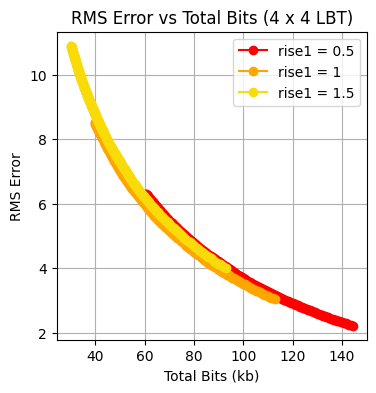

In [6]:
Y = lbt(X, N=4, s=1.31)

step = 17
print(f"Step = {step}")

k_list = [0.5, 1, 1.5]
decimal_range_stepsize = np.arange(10, 40, 0.1)
total_bits_list_vary_rise1 = []
rms_error_list_vary_rise1 = []

for r in k_list:
    # print(f"k = {k}")
    tot_bits_list = []
    rms_list = []
    for step in decimal_range_stepsize:
        Yq = quantise(Y, step, r*step)
        Yr = dct_regroup(Yq, N=4)
        tot_bits = dctbpp(Yr, N=4)
        tot_bits_list.append(tot_bits/1000) # in kb

        Z = ilbt(Yq, N=4, s=1.31)
        rms = np.std(X-Z)
        rms_list.append(rms)

    total_bits_list_vary_rise1.append(tot_bits_list)
    rms_error_list_vary_rise1.append(rms_list)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w', 
          'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'white', 
          'navy', 'purple', 'or÷ange', 'teal', 'lime', 'brown', 'pink', 'gray', 
          'olive', 'gold', 'skyblue', 'darkgreen', 'darkred', 'lightblue', 'lightgreen']
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
colors = ['#0084ff',"#80c1ff","#d1e9ff"]
colors = ['r','orange','#f8db09']

# Plotting the data
plt.figure(figsize=(3, 3))

for index, value in enumerate(k_list):
    plt.plot(total_bits_list_vary_rise1[index], rms_error_list_vary_rise1[index], marker='o', linestyle='-', color=colors[index], label='rise1 = '+str(k_list[index]))

# Adding title and labels
plt.title('RMS Error vs Total Bits (4 x 4 LBT)')
plt.xlabel('Total Bits (kb)')
plt.ylabel('RMS Error')
plt.legend()

# Adding grid
plt.grid(True)

# Showing the plot
plt.show()

In [7]:
# ------ set required bits -------
Y = lbt(X, N=4, s=1.31)

required_bits = 40960 # 5kb

def objective(step):
    Yq = quantise(Y, step, step*k)
    bits = bpp(Yq)*Yq.size
    if bits > required_bits:
        return np.abs(bits - required_bits) * 10 # Soft penalty, preserving the gradient
    else:
        return np.abs(bits - required_bits)

for k in [0.5,1.0,1.5]:
    print(f"k = {k}")

    result = minimize(objective, 20, method='Nelder-Mead')

    step_final = result.x[0]
    print(f"Step: {step_final}")

    Yq = quantise(Y, step_final, step_final*k)
    print(f"Bits: {bpp(Yq)*Yq.size}")

    Z = ilbt(Yq, N=4, s=1.31)
    print(f"RMS: {np.std(X-Z)}")

k = 0.5
Step: 96.65625
Bits: 40956.13667052539
RMS: 11.499753348208056
k = 1.0
Step: 56.5771484375
Bits: 40958.51335016674
RMS: 10.825088227475373
k = 1.5
Step: 41.064453125
Bits: 40959.47068719662
RMS: 11.116112075807752


Text(0, 0.5, 'RMS')

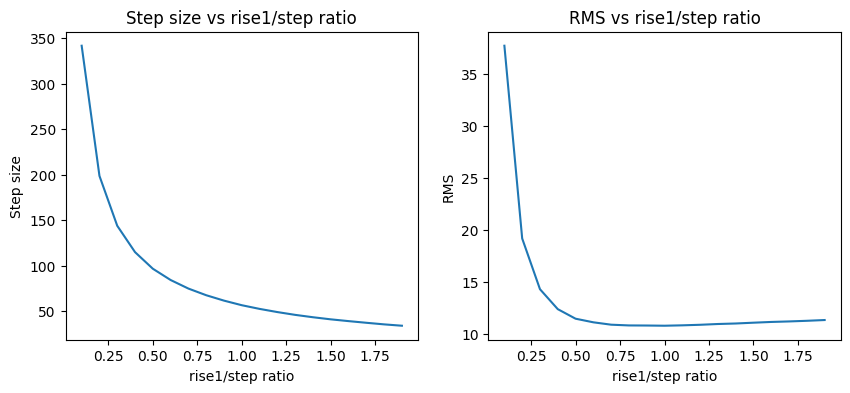

In [8]:
# Fix total bits, vary rise1, check optimised step and RMS

Y = lbt(X, N=4, s=1.31)

required_bits = 40960

k_list = np.arange(0.1, 2.0, 0.1)
step_list = np.zeros_like(k_list)
rms_list = np.zeros_like(k_list)

def objective(step):
    Yq = quantise(Y, step, step*k)
    bits = bpp(Yq)*Yq.size
    if bits > required_bits:
        return np.abs(bits - required_bits) * 10 # Soft penalty, preserving the gradient
    else:
        return np.abs(bits - required_bits)


for i in range(len(k_list)):
    k = k_list[i] 

    result = minimize(objective, 20, method='Nelder-Mead')

    step_final = result.x[0]
    step_list[i] = step_final

    Yq = quantise(Y, step_final, step_final*k)

    Z = ilbt(Yq, N=4, s=1.31)
    rms_list[i] = np.std(X-Z)

# plot
fig, axs = plt.subplots(1,2,figsize=(10,4))
# fig.suptitle(f"Graphs with varying k, constant required bits = {required_bits}")

axs[0].plot(k_list, step_list)
axs[0].set_title("Step size vs rise1/step ratio")
axs[0].set_xlabel("rise1/step ratio")
axs[0].set_ylabel("Step size")

axs[1].plot(k_list, rms_list)
axs[1].set_title("RMS vs rise1/step ratio")
axs[1].set_xlabel("rise1/step ratio")
axs[1].set_ylabel("RMS")
